Goal of this is to look at the sentences and correlations between correct predictions and other data fields.

In [2]:
from keras.models import load_model

# Put any of the models here
blstm_model = load_model('./models/atta_blstm_dropout6.hdf5')

In [3]:
from utils import *
from models import blstm_dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

import pandas as pd
import numpy as np

atta_df = pd.read_csv('/scratch/gussteen/final_project/attasidor.csv')

atta_df['word'] = atta_df['word'].astype(str)
atta_all_sents = atta_df.groupby('sent_id')['word'].apply(lambda x: ' '.join(x))

print("Total sentences:", len(atta_all_sents))

max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='UNK', filters='–—!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(atta_all_sents)

word_lookup = {v: k for k, v in tokenizer.word_index.items()} 

sentence_list = atta_df.groupby('sent_id')['word'].apply(list)
pos_list = atta_df.groupby('sent_id')['pos'].apply(list)

X_ids = []
X_before = []
X_after = []
y = []
for words, w_pos, s_id in zip(list(sentence_list), list(pos_list), list(sentence_list.index)):
    for ex_id, before, after, w in create_training_example(words, w_pos, s_id, tokenizer):
        X_ids.append(ex_id)
        X_before.append(before)
        X_after.append(after)
        y.append(w)
        
X_ids = np.array(X_ids)
X_before = np.array(X_before)
X_after = np.array(X_after)
y_cat = to_categorical(y, num_classes = max_words + 1)

Total sentences: 254711


In [4]:
# Get the predictions for the training data 
y_preds = blstm_model.predict([X_before, X_after])

In [5]:
cross_ent = - np.sum(y_cat * np.log(y_preds), axis = 1)

In [6]:
cross_ent.shape

(675621,)

In [7]:
pred_word = np.argmax(y_preds, axis=1)

In [8]:
pred_word

array([ 421, 5099,  328, ...,  394,  640,  147])

In [9]:
results_df = pd.DataFrame()
results_df['pred_word'] = pred_word
results_df['actual_word'] = y
results_df['cross_entropy'] = cross_ent
results_df['sent_id'] = X_ids
#results_df.index = X_ids

In [10]:
results_df['actual_word'] = results_df['actual_word'].apply(lambda i: word_lookup[i[0]])
results_df['pred_word'] = results_df['pred_word'].apply(lambda i: word_lookup[i])

In [11]:
sent_df = pd.DataFrame()
sent_df['sentence'] = atta_all_sents
sent_df['word_count'] = atta_df.groupby('sent_id')['word'].apply(len)
# Compute average cross_entropy for each sentence
sent_df['avg_cross_entropy'] = results_df.groupby('sent_id')['cross_entropy'].mean()

In [12]:
import matplotlib.pyplot as plt

# Correlation and plot for entropy and sentence length
res = sent_df[sent_df['avg_cross_entropy'].notna()][['word_count', 'avg_cross_entropy']]
by_wordcount = res.groupby('word_count')['avg_cross_entropy'].agg(['mean','std'])

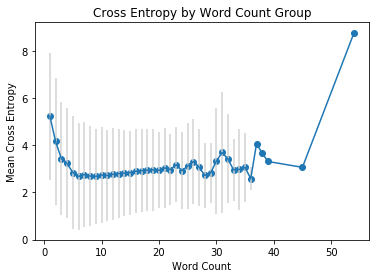

In [13]:
# by_wordcount_small = by_wordcount[by_wordcount.index < 25]
plt.scatter(by_wordcount.index, by_wordcount['mean'])
plt.errorbar(by_wordcount.index, by_wordcount['mean'], by_wordcount['std'], ecolor='#d3d3d3')
plt.xlabel('Word Count')
plt.ylabel('Mean Cross Entropy')
plt.title('Cross Entropy by Word Count Group')
plt.savefig('./results/cross_entropy_word_count.png')
#plt.show()

In [14]:
# Gets the minimum entropy for each actual word
min_entropy_word = results_df.loc[results_df.groupby('actual_word')['cross_entropy'].idxmin()]

In [15]:
# Join the sentence
# Get the top 20 predictions as latex table
pd.set_option('display.max_colwidth', -1)
print(min_entropy_word.join(sent_df, on='sent_id').sort_values(by='cross_entropy')[['actual_word', 'sentence']].head(20).to_latex(index=False))

\begin{tabular}{ll}
\toprule
   actual\_word &                                                                                                                   sentence \\
\midrule
 eurovision &  Robin Bengtsson får tävla för Sverige i musiktävlingen Eurovision Song Contest i Ukraina maj . \\
 för &  Regeringen föreslår att Centrum för lättläst ska stängas . \\
 eld &  Ungdomar har tänt eld på bilar och kastat sten på poliser och brandmän . \\
 champions &  Zlatans franska klubb PSG spelade oavgjort mot Manchester City i Champions League i fotboll . \\
 vållande &  Han döms inte för mord utan för brottet vållande till annans död . \\
 initiativ &  Feministiskt initiativ fick bara tre procent av rösterna . \\
 nationernas &  Det sade Förenta Nationernas chef Ban Ki-moon på måndagen . \\
 röda &  Kritiken växte när det kom fram att flera chefer i Röda korset också hade väldigt höga löner . \\
 tour &  Ett tag verkade det som om hon skulle missa tävlingen Tour de ski , som \\
 feministis